In [10]:
!pip install -q accelerate>=0.21.0 transformers[torch] torch datasets sacrebleu

In [11]:
from transformers import MarianMTModel, MarianTokenizer, T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset
import torch


In [58]:
dataset = load_dataset('wmt14', 'fr-en')


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/40836715 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [59]:
train_dataset = dataset['train']
val_dataset = dataset['validation']


In [ ]:
print("Training dataset:")
for i, r in enumerate(train_dataset[:5]['translation']):
    print(f"Example {i}:")
    print(f"Source: {r['en']}")
    print(f"Target: {r['fr']}")
    print()

print("Validation dataset:")
for i, r in enumerate(val_dataset[:5]['translation']):
    print(f"Example {i}:")
    print(f"Source: {r['en']}")
    print(f"Target: {r['fr']}")
    print()


Training dataset:
Example 0:
Source: Resumption of the session
Target: Reprise de la session

Example 1:
Source: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
Target: Je déclare reprise la session du Parlement européen qui avait été interrompue le vendredi 17 décembre dernier et je vous renouvelle tous mes vux en espérant que vous avez passé de bonnes vacances.

Example 2:
Source: Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.
Target: Comme vous avez pu le constater, le grand "bogue de l'an 2000" ne s'est pas produit. En revanche, les citoyens d'un certain nombre de nos pays ont été victimes de catastrophes naturelles qui ont vraiment été terribles.

Example 3:
Source: You have reques

50000
50000


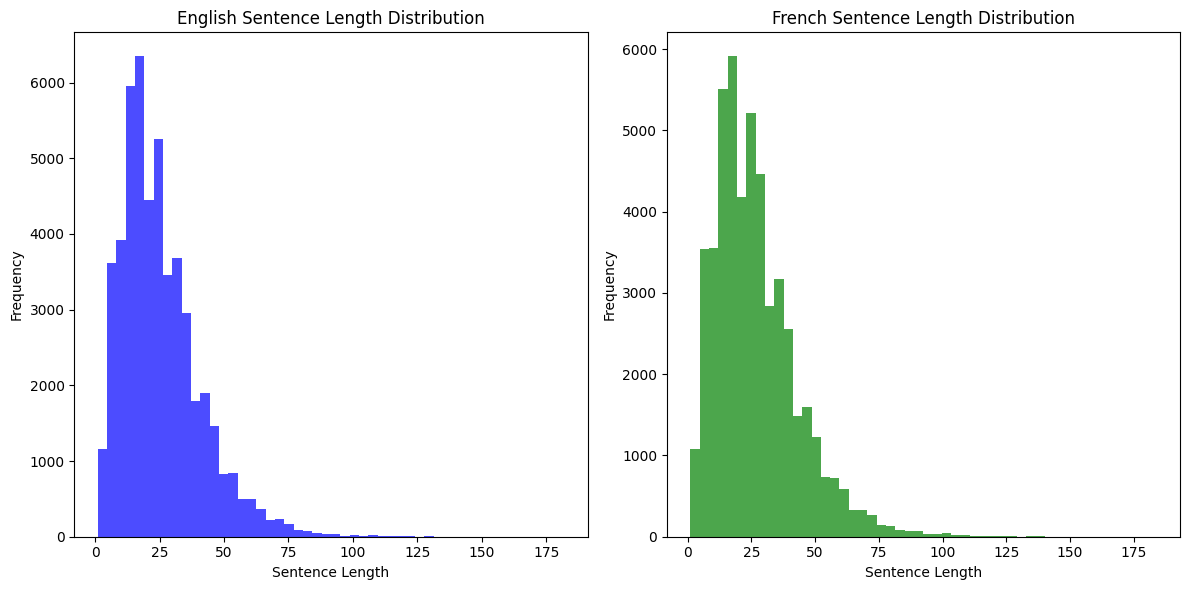

In [ ]:
import matplotlib.pyplot as plt

# Get lengths of English and French sentences
english_lengths = [len(sample['en'].split()) for sample in train_dataset[:50000]['translation']]
french_lengths = [len(sample['fr'].split()) for sample in train_dataset[:50000]['translation']]

print(len(english_lengths))
print(len(french_lengths))
# Plot the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(english_lengths, bins=50, color='blue', alpha=0.7, label='English')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('English Sentence Length Distribution')

plt.subplot(1, 2, 2)
plt.hist(french_lengths, bins=50, color='green', alpha=0.7, label='French')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('French Sentence Length Distribution')

plt.tight_layout()
plt.show()


In [63]:
from transformers import MarianMTModel, MarianTokenizer, GenerationConfig

model_name = 'Helsinki-NLP/opus-mt-en-fr'
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [64]:
print(torch.cuda.is_available())
# Move model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

True


MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [65]:
def tokenize_function(examples):
    examples=examples['translation']
    if model_name.startswith('Helsinki-NLP'):
        inputs = [r['en'] for r in examples]
        targets  = [r['fr'] for r in examples]
    else:
        inputs = ['translate English to French: ' + r['en'] for r in examples]
        targets = [r['fr'] for r in examples]

    inputs = tokenizer(inputs, padding='max_length', truncation=True, max_length=128)
    targets = tokenizer(targets, padding='max_length', truncation=True, max_length=128)

    inputs['labels'] = targets['input_ids']
    return inputs

In [ ]:
from datasets import Dataset, DatasetDict
import gc
from tqdm import tqdm


def accumulate_batches(dataset, batch_size, tokenize_function):
    num_batches = len(dataset) // batch_size + 1
    num_batches = 3 if num_batches < 5 else 70  # stricted because of time and memory limits
    print("Should use", len(dataset) // batch_size + 1, "batches, but will use", num_batches, "due to time/storage limits")

    tokenized_batches = []

    for i in tqdm(range(num_batches), desc="Processing batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(dataset))
        batch = dataset.select(range(start_idx, end_idx))

        tokenized_batch = Dataset.from_dict(tokenize_function(batch))
        tokenized_batches.append(tokenized_batch)

        del tokenized_batch
        gc.collect()

    # Concatenate all batches into a single Dataset
    concatenated_dict = {k: sum([batch[k] for batch in tokenized_batches], []) for k in tokenized_batches[0].column_names}
    concatenated_dataset = Dataset.from_dict(concatenated_dict)

    return concatenated_dataset


In [ ]:

# Tokenize the train and validation datasets in smaller batches
batch_size = 1000  # change the batch size according to storege / time limites

tokenized_train = accumulate_batches(train_dataset, batch_size, tokenize_function)
tokenized_val = accumulate_batches(val_dataset, batch_size, tokenize_function)


Should use 40837 batches, but will use 70 due to time/storage limits


Processing batches: 100%|██████████| 70/70 [00:38<00:00,  1.82it/s]


Should use 4 batches, but will use 3 due to time/storage limits


Processing batches: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


In [ ]:
print("train:"+str(len(tokenized_train)))
print("val:"+str(len(tokenized_val)))

train:70000
val:3000


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.509800,0.529052
2,0.441300,0.497490
3,0.414900,0.491057


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strate

TrainOutput(global_step=13125, training_loss=0.49957108444940473, metrics={'train_runtime': 5400.2873, 'train_samples_per_second': 38.887, 'train_steps_per_second': 2.43, 'total_flos': 7118656634880000.0, 'train_loss': 0.49957108444940473, 'epoch': 3.0})

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
model_save_path = '/content/drive/My Drive/MUN/Courses/ENGI-9867/Helsinki-NLP_trained_model.pt'
torch.save(model.state_dict(), model_save_path)

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)


{'eval_loss': 6.17617130279541, 'eval_runtime': 21.4914, 'eval_samples_per_second': 139.59, 'eval_steps_per_second': 8.748}


In [66]:
def translate(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to the appropriate device
    model.to(device)

    if model_name.startswith('Helsinki-NLP'):
        inputs = tokenizer(text, return_tensors='pt', padding=True)
    else:
        inputs = tokenizer('translate English to French: ' + text, return_tensors='pt', padding=True)

    # Move inputs to the appropriate device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(**inputs,max_new_tokens=50)
    # print(outputs)

    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

example_text = "Hello, how are you?"
print(translate(example_text))


Bonjour, comment allez-vous?


In [ ]:
test_dataset = load_dataset('wmt14', 'fr-en', split='test[:10%]')
references = [example['fr'] for example in test_dataset['translation']]
predictions = [
    translate(example['en']) for example in tqdm(test_dataset['translation'], total=len(test_dataset['translation']))
]

len(test_dataset)

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 300/300 [01:35<00:00,  3.16it/s]


300

In [ ]:
from datasets import load_metric
import sacrebleu
# Load metrics
bleu = load_metric('bleu')
meteor = load_metric('meteor')
ter = sacrebleu.metrics.TER()

def compute_meteor(predictions, references):
    results = meteor.compute(predictions=predictions, references=references)
    return results['meteor']
def compute_bleu(predictions, references):
    results = bleu.compute(predictions=predictions, references=references)
    return results['bleu']
def compute_ter(predictions, references):
    ter_score = ter.corpus_score(predictions, references)
    return ter_score.score
def evaluate_model(predictions, references):
    prepared_predictions = [pred.split() for pred in predictions]
    prepared_references = [[ref.split()] for ref in references]

    bleu_score = compute_bleu(prepared_predictions, prepared_references)
    meteor_score = compute_meteor(predictions, references)
    ter_score = compute_ter(predictions, references)

    print(f"BLEU score: {bleu_score}")
    print(f"METEOR score: {meteor_score}")
    print(f"TER score: {ter_score}")



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
evaluate_model(predictions,references)

BLEU score: 0.3679524286738066
METEOR score: 0.6452199050845169
TER score: 2435.614422369389


In [ ]:
print(translate("Here’s a complete example to ensure everything is in order"))

Voilà un exemple complet pour garantir que tout est en ordre


In [ ]:
print(translate("I want to have fun"))

Je veux m'amuser.


In [ ]:
model_name = 't5-small'
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Move model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
batch_size = 1000

t5_tokenized_train = accumulate_batches(train_dataset, batch_size, tokenize_function)
t5_tokenized_val = accumulate_batches(val_dataset, batch_size, tokenize_function)

Should use 40837 batches, but will use 70 due to time/storage limits


Processing batches: 100%|██████████| 70/70 [01:00<00:00,  1.16it/s]


Should use 4 batches, but will use 3 due to time/storage limits


Processing batches: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
)

In [ ]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=t5_tokenized_train,
    eval_dataset=t5_tokenized_val,
)

In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.403400,0.348046
2,0.399700,0.347668
3,0.396000,0.347504


TrainOutput(global_step=13125, training_loss=0.44702702927362353, metrics={'train_runtime': 4168.9061, 'train_samples_per_second': 50.373, 'train_steps_per_second': 3.148, 'total_flos': 7105444577280000.0, 'train_loss': 0.44702702927362353, 'epoch': 3.0})

In [ ]:
model_save_path = '/content/drive/My Drive/MUN/Courses/ENGI-9867/t5_small_trained_model.pt'
torch.save(model.state_dict(), model_save_path)

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)


{'eval_loss': 12.799932479858398, 'eval_runtime': 16.0927, 'eval_samples_per_second': 186.42, 'eval_steps_per_second': 11.682}


In [ ]:

t5_predictions = [
    translate(example['en']) for example in tqdm(test_dataset['translation'], total=len(test_dataset['translation']))
]
evaluate_model(t5_predictions,references)

100%|██████████| 300/300 [01:56<00:00,  2.58it/s]


BLEU score: 0.28927744184786097
METEOR score: 0.5706883854719655
TER score: 2060.3384841795437


In [ ]:
example_text = "Hello, how are you?"
print(translate(example_text))

Bonjour, comment êtes-vous?


In [ ]:
print(translate("I want to have fun"))

Je veux avoir des plaisirs


In [ ]:
print(translate("Here’s a complete example to ensure everything is in order"))

Voici un exemple complet pour s’assurer que tout est en ordre.


In [ ]:
print(translate("I love machine learning"))

Je suis en amour de l'apprentissage de la machine


In [27]:
# test loading the of the model from my drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# model_name = 'Helsinki-NLP/opus-mt-en-fr'
model_save_path = '/content/drive/My Drive/MUN/Courses/ENGI-9867/Helsinki-NLP_trained_model.pt'

# Initialize the model and tokenizer
helsinki_model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-en-fr')
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-en-fr')

# Load the saved weights
helsinki_model.load_state_dict(torch.load(model_save_path))


<All keys matched successfully>

In [42]:
# model_name = 't5-small'
model_save_path = '/content/drive/My Drive/MUN/Courses/ENGI-9867/t5_small_trained_model.pt'

# Initialize the model and tokenizer
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Load the saved state dictionary into the model
t5_model.load_state_dict(torch.load(model_save_path))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<All keys matched successfully>

In [51]:
def translateHelsinki(text,helsinki_model):
    model_name = 'Helsinki-NLP/opus-mt-en-fr'
    return translate(text,helsinki_model)
def translateT5(text,t5_model):
    model_name = 't5-small'
    return translate(text,t5_model)

In [52]:
text = "some random setence"
print(translateHelsinki(text,helsinki_model))
print("vs")
print(translateT5(text,t5_model=t5_model))

TypeError: translate() takes 1 positional argument but 2 were given